In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as web
from datetime import datetime
from sklearn import preprocessing
import numpy as np
import keras
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import History 
from sklearn.metrics import mean_squared_error
import pandas_ta as pta

from keras.callbacks import EarlyStopping
es = EarlyStopping(patience=20, restore_best_weights=True)

In [3]:
def add_technical_indicators(stock_df):
    # Adding of technical indicators to data frame (Exponential moving average and Bollinger Band)
    edited_df = pd.DataFrame()
    #edited_df is made in order to generate the order needed for the finta library
    edited_df['open'] = stock_df['Open']
    edited_df['high'] = stock_df['High']
    edited_df['low'] = stock_df['Low']
    edited_df['close'] = stock_df['Close']
    edited_df['volume'] = stock_df['Volume']
    edited_df['Adj Close'] = stock_df['Adj Close']

    edited_df['per_change_close'] = ((edited_df['close'] - edited_df['close'].shift(-1))/edited_df['close'].shift(-1))*100
    edited_df['ema21'] = pta.ema(edited_df['close'], length=21)
    edited_df['ema55'] = pta.ema(edited_df['close'], length=55)
    edited_df['ema200'] = pta.ema(edited_df['close'], length=200)
    edited_df['rsi'] = pta.rsi(edited_df['close'], length = 14)
    edited_df['obv'] =pta.obv(edited_df['close'], edited_df['volume'])
    edited_df['adx'] = pta.adx(edited_df['high'],edited_df['low'],edited_df['close'],length=14)['ADX_14']
    
    edited_df['h_l'] = edited_df['high']-edited_df['low']
    edited_df['c_o'] = edited_df['close']-edited_df['open']
    edited_df['d_ema21'] = edited_df['close']-edited_df['ema21']
    edited_df['d_ema55'] = edited_df['close']-edited_df['ema55']
    edited_df['d_ema200']= edited_df['close']-edited_df['ema200']
    edited_df['bb_upper'] = pta.bbands(edited_df['close'],length=20,std=2)['BBU_20_2.0']
    edited_df['bb_lower'] = pta.bbands(edited_df['close'],length=20,std=2)['BBL_20_2.0']
    edited_df['d_bb_upper'] = edited_df['close']-edited_df['bb_upper']
    edited_df['d_bb_lower'] = edited_df['close']-edited_df['bb_upper']
    edited_df['d_high'] = edited_df['close']-edited_df['high']
    edited_df['d_low'] = edited_df['close']-edited_df['low']
    edited_df['d_open'] = edited_df['close']-edited_df['open']
    edited_df.head()

    return edited_df

In [4]:
def train_test_split_preparation(new_df, data_set_points, train_split):
    new_df = new_df.loc[1:]

    #Preparation of train test set.
    train_indices = int(new_df.shape[0] * train_split)

    train_data = new_df[:train_indices]
    test_data = new_df[train_indices:]
    test_data = test_data.reset_index()
    test_data = test_data.drop(columns = ['index'])
    
    train_arr = np.diff(train_data.loc[:, :].values, axis = 0)
    test_arr = np.diff(test_data.loc[:, :].values, axis = 0)


    X_train = np.array([train_arr[i : i + data_set_points] for i in range(len(train_arr) - data_set_points)])


    y_train = np.array([train_arr[i + data_set_points] for i in range(len(train_arr) - data_set_points)])

    y_valid = np.array([train_data['Adj Close'][-(int)(len(y_train)/10):].copy()])

    y_valid = y_valid.flatten()
    y_valid = np.expand_dims(y_valid, -1)

    X_test = np.array([test_arr[i : i + data_set_points] for i in range(len(test_arr) - data_set_points)])

    y_test = np.array([test_data['Adj Close'][i + data_set_points] for i in range(len(test_arr) - data_set_points)])


    return X_train, y_train, X_test, y_test, test_data

In [6]:
def lstm_model(X_train, y_train, data_set_points):
    #Setting of seed (to maintain constant result)
    tf.random.set_seed(20)
    np.random.seed(10)

    lstm_input = Input(shape=(data_set_points, X_train.shape[2]), name='input_for_lstm')

    inputs = LSTM(21, name='first_layer', return_sequences = True)(lstm_input)

    inputs = Dropout(0.1, name='first_dropout_layer')(inputs)
    inputs = LSTM(32, name='lstm_1')(inputs)
    inputs = Dropout(0.05, name='lstm_dropout_1')(inputs) #Dropout layers to prevent overfitting
    inputs = Dense(32, name='first_dense_layer')(inputs)
    inputs = Dense(1, name='dense_layer')(inputs)
    output = Activation('linear', name='output')(inputs)

    model = Model(inputs=lstm_input, outputs=output)
    adam = optimizers.Adam(lr = 0.002)

    model.compile(optimizer=adam, loss='mse')
    model.fit(x=X_train, y=y_train, batch_size=15, epochs=25, shuffle=True, validation_split = 0.1)

    return model

In [11]:
stock_df = pd.read_csv("AAPL.csv")
#stock_df = pd.read_csv("TCS.BO.csv")

In [13]:
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-03-13,34.712502,34.857498,34.705002,34.799999,32.856758,69686800
1,2017-03-14,34.825001,34.912498,34.709999,34.747501,32.807194,61236400
2,2017-03-15,34.852501,35.187500,34.757500,35.115002,33.154182,102767200
3,2017-03-16,35.180000,35.255001,35.064999,35.172501,33.208458,76928000
4,2017-03-17,35.250000,35.250000,34.972500,34.997501,33.043232,175540000


In [14]:
train_split = 0.7

data_set_points = 21

new_df = stock_df.copy()
#Addition of on balance volume, exponential moving average and bollinger bands.
new_df = add_technical_indicators(new_df)
new_df  = new_df.dropna()  
#new_df = on_balance_volume_creation(stock_df)
print(new_df.columns)
new_df = new_df[['Adj Close']]
#Train test split

X_train, y_train, X_test, y_test, test_data = train_test_split_preparation(new_df, data_set_points, train_split)

Index(['open', 'high', 'low', 'close', 'volume', 'Adj Close',
       'per_change_close', 'ema21', 'ema55', 'ema200', 'rsi', 'obv', 'adx',
       'h_l', 'c_o', 'd_ema21', 'd_ema55', 'd_ema200', 'bb_upper', 'bb_lower',
       'd_bb_upper', 'd_bb_lower', 'd_high', 'd_low', 'd_open'],
      dtype='object')


In [15]:
#Training of model
model = lstm_model(X_train, y_train, data_set_points)

#prediction of model
y_pred = model.predict(X_test)

2022-03-14 08:42:42.021622: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


/Users/vivek/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/44 [==============================] - 3s 22ms/step - loss: 1.8836 - val_loss: 9.6779
Epoch 2/25
44/44 [==============================] - 0s 9ms/step - loss: 1.8685 - val_loss: 9.5715
Epoch 3/25
44/44 [==============================] - 0s 9ms/step - loss: 1.8584 - val_loss: 9.7755
Epoch 4/25
44/44 [==============================] - 0s 9ms/step - loss: 1.8680 - val_loss: 9.9225
Epoch 5/25
44/44 [==============================] - 0s 9ms/step - loss: 1.8541 - val_loss: 9.9643
Epoch 6/25
44/44 [==============================] - 0s 9ms/step - loss: 1.8488 - val_loss: 9.4457
Epoch 7/25
44/44 [==============================] - 0s 9ms/step - loss: 1.8509 - val_loss: 10.1441
Epoch 8/25
44/44 [==============================] - 0s 9ms/step - loss: 1.8280 - val_loss: 11.9118
Epoch 9/25
44/44 [==============================] - 0s 9ms/step - loss: 1.8297 - val_loss: 10.8724
Epoch 10/25
44/44 [==============================] - 0s 9ms/step - loss: 1.8034 - val_loss: 9.3716
Epoch 11/25
44/44 [=======

In [16]:
y_pred[0:5]

array([[2.2814581],
       [1.1877909],
       [1.6506736],
       [1.9703639],
       [1.9755558]], dtype=float32)

In [17]:
y_pred = y_pred.flatten()

#actual represents the test set's actual stock prices
actual = np.array([test_data['Adj Close'][i + data_set_points].copy() for i in range(len(test_data) - data_set_points)])

#reference represents the stock price of the point before the prediction, so we can iteratively add the difference
reference = test_data['Adj Close'][data_set_points - 1]

predicted = []

predicted.append(reference)

#adding of difference and appending to the list
for i in y_pred:
    reference += i
    predicted.append(reference)

predicted = np.array(predicted)

print(predicted[-5:])

[279.62091711 281.0600529  284.07242516 280.14776376 280.42706576]


In [56]:
df_final = pd.DataFrame({"actual":actual[1:],"y_pred":y_pred,"predicted":predicted[1:]})
df_final["actual_plus_prediction"] = df_final["actual"].shift(-1)+ df_final["y_pred"]
df_final.head()

,actual,y_pred,predicted,actual_plus_prediction
0,129.952271,2.281458,132.323069,133.355387
1,131.073929,1.187791,133.510860,129.214433
2,128.026642,1.650674,135.161534,129.498628
3,127.847954,1.970364,137.131897,131.892865
4,129.922501,1.975556,139.107453,129.932702


In [57]:
df_final.loc[1:]["actual_diff"] = np.diff(df_final['actual'].values, axis = 0)

/var/folders/8z/_088r0914q708yf3k91yqk940000gn/T/ipykernel_2531/128014332.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.loc[1:]["actual_diff"] = np.diff(df_final['actual'].values, axis = 0)


In [58]:
df_final.tail()

,actual,y_pred,predicted,actual_plus_prediction
292,159.300003,-1.591999,279.620917,155.848003
293,157.440002,1.439136,281.060053,164.389133
294,162.949997,3.012372,284.072425,161.532376
295,158.520004,-3.924661,280.147764,150.805335
296,154.729996,0.279302,280.427066,NaN


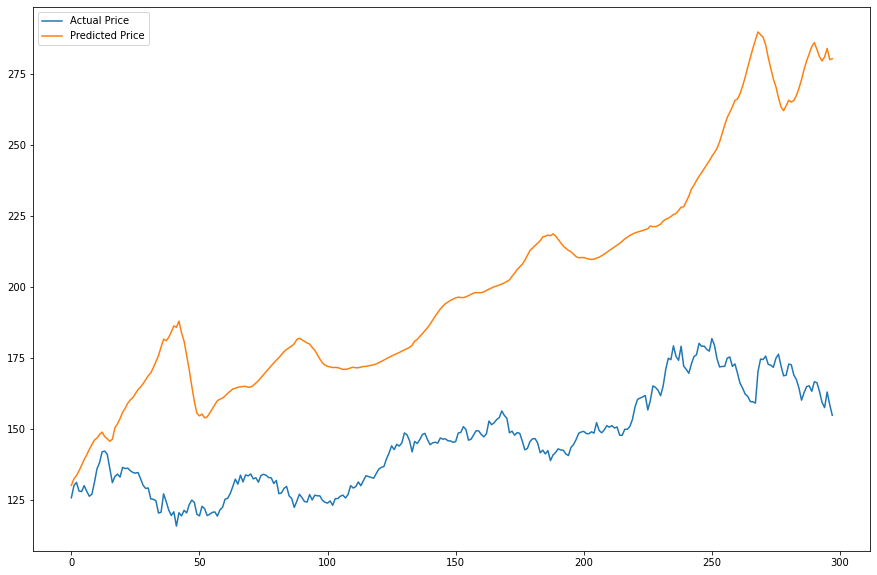

In [59]:
real = plt.plot(actual, label='Actual Price')
pred = plt.plot(predicted, label='Predicted Price')

plt.legend(['Actual Price', 'Predicted Price'])
plt.gcf().set_size_inches(15, 10, forward=True)

plt.show()

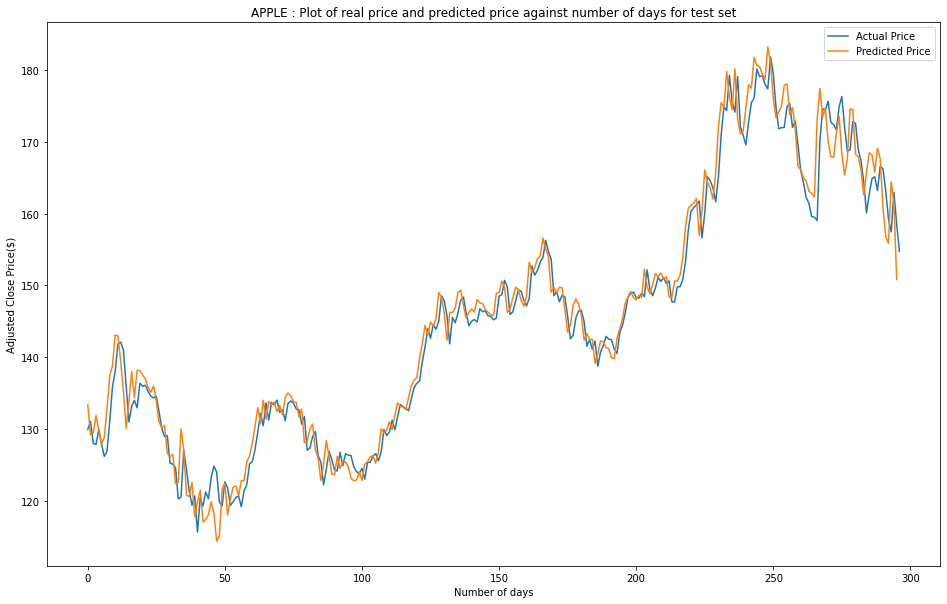

In [60]:
plt.gcf().set_size_inches(16, 10, forward=True)
plt.title('APPLE : Plot of real price and predicted price against number of days for test set')
plt.xlabel('Number of days')
plt.ylabel('Adjusted Close Price($)')

plt.plot(df_final["actual"], label='Actual Price')
plt.plot(df_final["actual_plus_prediction"], label='Predicted Price')

#print(mean_squared_error(actual[1:], new, squared = False))

#plotting of model  
plt.legend(['Actual Price', 'Predicted Price'])


plt.show()

In [61]:
df_final["residuos"] = df_final["actual"] - df_final["actual_plus_prediction"]

In [62]:
mpe = abs(df_final["actual_plus_prediction"] / df_final["actual"]).mean(axis = 0)

rmse = (df_final["residuos"] ** 2).mean(axis = 0) ** 0.5
print(mpe, rmse)

1.0041008286353108 2.994178977503293


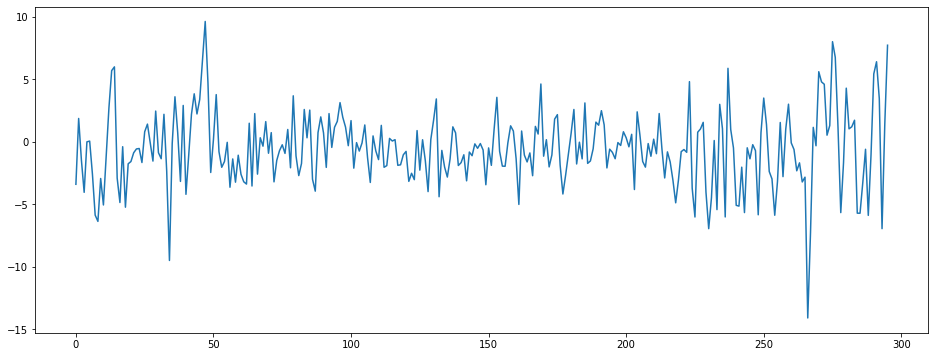

In [63]:
plt.figure(figsize=(16,6))
plt.plot(df_final["residuos"])